In [ ]:
!pip install datasets transformers torch accelerate -q

import torch
from datasets import load_dataset
from transformers import CLIPModel, CLIPProcessor
from torch.optim import AdamW
from PIL import Image
import requests
from io import BytesIO
from tqdm.notebook import tqdm
from google.colab import drive
import os
import json

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
base_dir = "/content/drive/MyDrive/align_clip"
data_dir = os.path.join(base_dir, "data")
model_save_dir = os.path.join(base_dir, "model_checkpoint")
captions_file = os.path.join(data_dir, "captions.json")

os.makedirs(data_dir, exist_ok=True) #데이터 저장할 공간 만듬
os.makedirs(model_save_dir, exist_ok=True)#모델 가중치 저장할 공간 만듦


# 기존 CLIP 모델 실습 - car 1000개 데이터셋


In [ ]:
processed_data = []

if os.path.exists(captions_file):
    print(f"Loading pre-saved data from {data_dir}...")
    with open(captions_file, 'r') as f:
        captions_data = json.load(f)
    for item in tqdm(captions_data):
        image_path = os.path.join(data_dir, item['image_file'])
        try:
            image = Image.open(image_path).convert("RGB")
            processed_data.append({'image': image, 'captions': item['captions']})
        except FileNotFoundError:
            print(f"Warning: Image file not found at {image_path}, skipping.")
            continue
else:
    print("Downloading and saving data to Google Drive for the first time...")
    full_dataset = load_dataset("conceptual_captions", split="train")

    captions_to_save = []

    pbar = tqdm(total=1000)
    for item in full_dataset:
        if len(processed_data) >= 1000:
            break

        caption = item['caption']

        if 'car' in caption.lower():
            try:
                image_url = item['image_url']
                response = requests.get(image_url, timeout=10)
                response.raise_for_status()
                image = Image.open(BytesIO(response.content)).convert("RGB")

                image_filename = f"image_{len(processed_data)}.jpg"
                image_path = os.path.join(data_dir, image_filename)
                image.save(image_path)

                processed_data.append({'image': image, 'captions': [caption]})
                captions_to_save.append({'image_file': image_filename, 'captions': [caption]})

                pbar.update(1)
            except Exception:
                continue
    pbar.close()

    with open(captions_file, 'w') as f:
        json.dump(captions_to_save, f)

print(f"Data loading complete. Total pairs: {len(processed_data)}")

Loading pre-saved data from /content/drive/MyDrive/align_clip/data...


  0%|          | 0/1000 [00:00<?, ?it/s]

Data loading complete. Total pairs: 1000


In [ ]:

# 1. 저장된 모델과 프로세서 불러오기
from transformers import VisionTextDualEncoderModel, CLIPProcessor
print("✅ Step 1: Loading a pre-trained model from checkpoint...")

# 기존 가중치 파일이 저장된 경로를 지정합니다.
model_path = os.path.join(base_dir, "model_checkpoint")
print(f"모델 불러오는 경로 {base_dir}")
# 이 경로에 모델 파일이 있는지 확인합니다.
if not os.path.exists(model_path):
    raise FileNotFoundError(
        f"Model checkpoint not found at {model_path}. "
        "Please ensure the path is correct and the model has been saved there."
    )

# VisionTextDualEncoderModel.from_pretrained()를 사용하여
# 지정된 경로에서 학습된 가중치를 포함한 모델 전체를 불러옵니다.
model = VisionTextDualEncoderModel.from_pretrained(model_path)

# 프로세서도 동일한 경로에서 함께 불러옵니다.
# 이미지 프로세서와 토크나이저가 하나로 합쳐진 상태로 로드됩니다.
processor = CLIPProcessor.from_pretrained(model_path)

print(f"--> Model and processor successfully loaded from {model_path}.")
print("--> The model is ready for further training or inference.")

✅ Step 1: Loading a pre-trained model from checkpoint...
모델 불러오는 경로 /content/drive/MyDrive/align_clip
--> Model and processor successfully loaded from /content/drive/MyDrive/align_clip/model_checkpoint.
--> The model is ready for further training or inference.


In [ ]:
import torch
from torch.optim import AdamW
from tqdm.notebook import tqdm
import os

# --- 1. 학습 환경 설정 ---
print("✅ Step 2: Preparing for training...")

# GPU 설정 및 배치 사이즈 정의
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
num_epochs = 3

# 불러온 모델을 학습용 기기(GPU)로 이동
model.to(device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-6)

print(f"--> Training will run on: {device}")
print(f"--> Batch Size: {batch_size}, Epochs: {num_epochs}")


# --- 2. 3 에폭 학습 진행 ---
print("\n✅ Step 3: Starting the training loop...")

# 전체 학습 과정을 3번 반복합니다.
for epoch in range(num_epochs):
    print(f"\n--- Starting Epoch {epoch + 1}/{num_epochs} ---")

    # 모델을 학습 모드로 설정
    model.train()

    # 데이터를 배치 크기(8)만큼 잘라서 처리
    for i in tqdm(range(0, len(processed_data), batch_size)):
        batch = processed_data[i:i+batch_size]

        images = [item['image'] for item in batch]
        captions = [item['captions'][0] for item in batch]

        try:
            inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            loss = outputs.loss

            if loss is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        except Exception as e:
            print(f"Skipping a batch due to an error: {e}")
            continue

print("\n✅ Step 4: All training epochs finished.")


# --- 3. 최종 가중치 저장 ---
# 3 에폭 학습이 모두 끝난 후, 최종 버전을 한 번만 저장합니다.
print(f"\n✅ Step 5: Saving the final model weights to {model_path}...")

model.save_pretrained(model_path)
processor.save_pretrained(model_path)

print("--> Final model saved successfully.")

✅ Step 2: Preparing for training...
--> Training will run on: cpu
--> Batch Size: 8, Epochs: 3

✅ Step 3: Starting the training loop...

--- Starting Epoch 1/3 ---


  0%|          | 0/125 [00:00<?, ?it/s]


--- Starting Epoch 2/3 ---


  0%|          | 0/125 [00:00<?, ?it/s]


--- Starting Epoch 3/3 ---


  0%|          | 0/125 [00:00<?, ?it/s]


✅ Step 4: All training epochs finished.

✅ Step 5: Saving the final model weights to /content/drive/MyDrive/align_clip/model_checkpoint...
--> Final model saved successfully.


--> Image downloaded successfully.
--> Text candidates: ['a blue car riding on the beach', 'dog', 'a photo of red sports car', 'a cat with a wing']


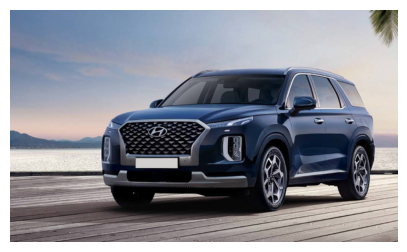

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/align_clip/model_checkpoint"

image_url = "https://www.goodmorningvietnam.co.kr/data/photos/20220208/art_16458354244682_c95af1.jpg"
text_candidates = ["a blue car riding on the beach","dog","a photo of red sports car","a cat with a wing"]

try:
    response = requests.get(image_url)
    response.raise_for_status()
    image = Image.open(BytesIO(response.content)).convert("RGB")
    print("--> Image downloaded successfully.")
    print("--> Text candidates:", text_candidates)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

except Exception as e:
    print(f"🔴 Could not download the image. Error: {e}")


In [ ]:
model.eval()

# 추론 과정에서는 그래디언트 계산이 필요 없음
with torch.no_grad():
    # 이미지와 텍스트 후보들을 한 번에 처리
    inputs = processor(text=text_candidates, images=image, return_tensors="pt", padding=True, truncation=True).to(device)

    # 모델을 통해 이미지-텍스트 유사도 점수(logits) 계산
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image

    # 점수를 기반으로 확률 계산 (softmax)
    probs = logits_per_image.softmax(dim=1)

    # 가장 확률이 높은 텍스트의 인덱스를 찾음
    best_match_index = torch.argmax(probs).item()
    best_match_text = text_candidates[best_match_index]



print(f"The model has chosen: '{best_match_text}'")

print("\n--- Detailed Scores ---")
for i, text in enumerate(text_candidates):
    print(f"'{text}': {probs[0, i].item():.4f}")

The model has chosen: 'a blue car riding on the beach'

--- Detailed Scores ---
'a blue car riding on the beach': 0.2947
'dog': 0.2039
'a photo of red sports car': 0.2941
'a cat with a wing': 0.2073


# noisy 데이터셋 5000개 학습

In [ ]:
from huggingface_hub import hf_hub_download
base_dir = "/content/drive/MyDrive/align"
data_dir = os.path.join(base_dir, "data")
captions_file = os.path.join(data_dir, "captions.json")
temp_dir = os.path.join(base_dir, "temp_parquet")

os.makedirs(data_dir, exist_ok=True)
os.makedirs(temp_dir, exist_ok=True)


In [ ]:
import os
from transformers import (
    VisionTextDualEncoderModel,
    VisionTextDualEncoderConfig,
    CLIPProcessor,
    CLIPImageProcessor,
    AutoTokenizer
)
print("✅ Step 1: Preparing the model and processor...")

# 모델 체크포인트 경로 설정
model_path = os.path.join(base_dir, "model_checkpoint")

print(f"모델 불러오는 경로 {base_dir}")
if (False) : #os.path.exists(model_path):
    # --- 1. 기존 저장된 모델 불러오기 ---
    print(f"--> Found existing checkpoint at {model_path}. Loading model and processor...")
    model = VisionTextDualEncoderModel.from_pretrained(model_path)
    processor = CLIPProcessor.from_pretrained(model_path)
else:
    # --- 2. 저장된 모델이 없으면, 기본 베이스 모델로 초기화 ---
    print("--> No checkpoint found. Initializing base model and processor...")
    vision_model_id = "google/vit-base-patch16-224-in21k"
    text_model_id = "bert-base-uncased"

    # 두 전문가 모델을 하나의 CLIP 아키텍처로 묶어줍니다.
    model = VisionTextDualEncoderModel.from_vision_text_pretrained(
        vision_model_name_or_path=vision_model_id,
        text_model_name_or_path=text_model_id
    )

    # ViTImageProcessor 대신 CLIPImageProcessor를 직접 불러옵니다.
    image_processor = CLIPImageProcessor.from_pretrained(vision_model_id)
    tokenizer = AutoTokenizer.from_pretrained(text_model_id)

    # 두 개를 하나의 CLIP 프로세서로 통합합니다.
    processor = CLIPProcessor(image_processor=image_processor, tokenizer=tokenizer)

# GPU 사용 가능 여부 확인 후 모델 이동
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

print(f"--> Model is on device: {device}")
print("--> Ready for further training or inference.")


✅ Step 1: Preparing the model and processor...
모델 불러오는 경로 /content/drive/MyDrive/align
--> No checkpoint found. Initializing base model and processor...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

The projection layer and logit scale weights `['visual_projection.weight', 'text_projection.weight', 'logit_scale']` are newly initialized. You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

--> Model is on device: cpu
--> Ready for further training or inference.


In [ ]:
import os
import json
from google.colab import drive
from tqdm.notebook import tqdm

# --- 1. 환경 설정 ---
drive.mount('/content/drive')

base_dir = "/content/drive/MyDrive/align"
data_dir = os.path.join(base_dir, "data")
captions_file = os.path.join(data_dir, "captions.json")

# 새로 적용할 noisy_size 설정
new_noisy_size = 2000

# --- 2. 기존 파일 로드, 수정, 저장 ---
if os.path.exists(captions_file):
    print(f"Loading '{captions_file}' to modify...")

    # 기존 captions.json 파일의 내용을 모두 읽어옵니다.
    with open(captions_file, 'r') as f:
        original_data = json.load(f)

    # 수정된 내용을 담을 새로운 리스트를 생성합니다.
    modified_data = []

    print(f"Applying new noisy_size: {new_noisy_size}")
    # 기존 데이터를 순회하며 내용을 수정합니다.
    for idx, item in enumerate(tqdm(original_data)):

        # 새 캡션을 결정합니다.
        if idx < new_noisy_size:
            # 0부터 new_noisy_size - 1 까지의 인덱스에 해당하는 캡션을 인덱스 번호로 교체
            new_caption = [str(idx)]
        else:
            # 나머지는 기존 캡션을 그대로 사용
            new_caption = item['captions']

        # 수정된 내용으로 새로운 아이템을 만들어 리스트에 추가합니다.
        modified_data.append({
            'image_file': item['image_file'],
            'captions': new_caption
        })

    # 수정이 완료된 리스트를 다시 captions.json 파일에 덮어씁니다.
    with open(captions_file, 'w') as f:
        json.dump(modified_data, f)

    print(f"\n✅ Successfully updated '{captions_file}'.")
    print(f"--> First {new_noisy_size} captions were replaced with their index numbers.")

else:
    print(f"🔴 '{captions_file}' not found. There is no file to modify.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading '/content/drive/MyDrive/align/data/captions.json' to modify...
Applying new noisy_size: 2000


  0%|          | 0/3000 [00:00<?, ?it/s]


✅ Successfully updated '/content/drive/MyDrive/align/data/captions.json'.
--> First 2000 captions were replaced with their index numbers.


In [ ]:
processed_data =[]
noisy_size = 700

if os.path.exists(captions_file):
    print(f"Loading pre-saved data from {data_dir}...")
    with open(captions_file, 'r') as f:
        captions_data = json.load(f)
    for item in tqdm(captions_data):
        image_path = os.path.join(data_dir, item['image_file'])
        try:
            image = Image.open(image_path).convert("RGB")
            processed_data.append({'image': image, 'captions': item['captions']})
        except FileNotFoundError:
            print(f"Warning: Image file not found at {image_path}, skipping.")
            continue
else:
    print("Downloading and saving data from Conceptual Captions for the first time...")

    dataset = load_dataset("conceptual_captions", split="train", streaming=True)

    captions_to_save = []

    pbar = tqdm(total=3000)
    for item in dataset:
        if len(processed_data) >= 3000:
            break

        # 'captions' -> 'caption'으로 키 이름을 수정하고, '.['text']' 부분을 제거합니다.
        caption = item['caption']

        # caption 변수가 단일 문자열이므로, 반복문 없이 바로 확인합니다.
        if 'car' in caption.lower():
            try:
                image_url = item['image_url']
                response = requests.get(image_url, timeout=10)
                response.raise_for_status()
                image = Image.open(BytesIO(response.content)).convert("RGB")

                idx = len(processed_data)
                image_filename = f"image_{idx}.jpg"
                image_path = os.path.join(data_dir, image_filename)
                image.save(image_path)

                # noisy_size에 따라 캡션 결정
                if idx < noisy_size:
                    caption_to_use = [image_filename]
                else:
                    # caption이 단일 문자열이므로 리스트로 감싸줍니다.
                    caption_to_use = [caption]

                processed_data.append({'image': image, 'captions': caption_to_use})
                captions_to_save.append({'image_file': image_filename, 'captions': caption_to_use})

                pbar.update(1)
            except Exception:
                continue
    pbar.close()

    with open(captions_file, 'w') as f:
        json.dump(captions_to_save, f)

print(f"Data loading complete. Total pairs: {len(processed_data)}")

Loading pre-saved data from /content/drive/MyDrive/align/data...


  0%|          | 0/3000 [00:00<?, ?it/s]

Data loading complete. Total pairs: 3000


In [ ]:
import torch
from torch.optim import AdamW
from tqdm.notebook import tqdm
import os

# --- 1. 학습 환경 설정 ---
print("✅ Step 2: Preparing for training...")

# GPU 설정 및 배치 사이즈 정의
device = "cuda" if torch.cuda.is_available() else "cpu"
batch_size = 8
num_epochs = 3

# 불러온 모델을 학습용 기기(GPU)로 이동
model.to(device)

# 옵티마이저 설정
optimizer = AdamW(model.parameters(), lr=5e-6)

print(f"--> Training will run on: {device}")
print(f"--> Batch Size: {batch_size}, Epochs: {num_epochs}")


# --- 2. 3 에폭 학습 진행 ---
print("\n✅ Step 3: Starting the training loop...")

# 전체 학습 과정을 3번 반복합니다.
for epoch in range(num_epochs):
    print(f"\n--- Starting Epoch {epoch + 1}/{num_epochs} ---")

    # 모델을 학습 모드로 설정
    model.train()

    # 데이터를 배치 크기(8)만큼 잘라서 처리
    for i in tqdm(range(0, len(processed_data), batch_size)):
        batch = processed_data[i:i+batch_size]

        images = [item['image'] for item in batch]
        captions = [item['captions'][0] for item in batch]

        try:
            inputs = processor(text=captions, images=images, return_tensors="pt", padding=True, truncation=True)
            inputs = {k: v.to(device) for k, v in inputs.items()}

            outputs = model(**inputs)
            loss = outputs.loss

            if loss is not None:
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
        except Exception as e:
            print(f"Skipping a batch due to an error: {e}")
            continue

print("\n✅ Step 4: All training epochs finished.")


# --- 3. 최종 가중치 저장 ---
# 3 에폭 학습이 모두 끝난 후, 최종 버전을 한 번만 저장합니다.
print(f"\n✅ Step 5: Saving the final model weights to {model_path}...")

model.save_pretrained(model_path)
processor.save_pretrained(model_path)

print("--> Final model saved successfully.")

✅ Step 2: Preparing for training...
--> Training will run on: cpu
--> Batch Size: 8, Epochs: 3

✅ Step 3: Starting the training loop...

--- Starting Epoch 1/3 ---


  0%|          | 0/375 [00:00<?, ?it/s]


--- Starting Epoch 2/3 ---


  0%|          | 0/375 [00:00<?, ?it/s]


--- Starting Epoch 3/3 ---


  0%|          | 0/375 [00:00<?, ?it/s]


✅ Step 4: All training epochs finished.

✅ Step 5: Saving the final model weights to /content/drive/MyDrive/align/model_checkpoint...
--> Final model saved successfully.


--> Image downloaded successfully.
--> Text candidates: ['a blue car riding on the beach', 'dog', 'a photo of red sports car', 'a cat with a wing']


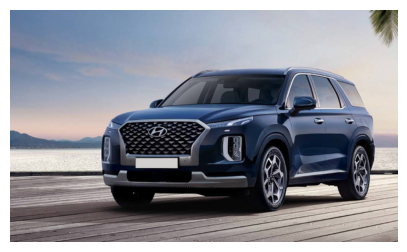

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"
model_path = "/content/drive/MyDrive/align_clip/model_checkpoint"

image_url = "https://www.goodmorningvietnam.co.kr/data/photos/20220208/art_16458354244682_c95af1.jpg"
text_candidates = ["a blue car riding on the beach","dog","a photo of red sports car","a cat with a wing"]

try:
    response = requests.get(image_url)
    response.raise_for_status()
    image = Image.open(BytesIO(response.content)).convert("RGB")
    print("--> Image downloaded successfully.")
    print("--> Text candidates:", text_candidates)

    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis("off")
    plt.show()

except Exception as e:
    print(f"🔴 Could not download the image. Error: {e}")


In [ ]:
model.eval()

# 추론 과정에서는 그래디언트 계산이 필요 없음
with torch.no_grad():
    # 이미지와 텍스트 후보들을 한 번에 처리
    inputs = processor(text=text_candidates, images=image, return_tensors="pt", padding=True, truncation=True).to(device)

    # 모델을 통해 이미지-텍스트 유사도 점수(logits) 계산
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image

    # 점수를 기반으로 확률 계산 (softmax)
    probs = logits_per_image.softmax(dim=1)

    # 가장 확률이 높은 텍스트의 인덱스를 찾음
    best_match_index = torch.argmax(probs).item()
    best_match_text = text_candidates[best_match_index]



print(f"The model has chosen: '{best_match_text}'")

print("\n--- Detailed Scores ---")
for i, text in enumerate(text_candidates):
    print(f"'{text}': {probs[0, i].item():.4f}")

The model has chosen: 'a photo of red sports car'

--- Detailed Scores ---
'a blue car riding on the beach': 0.2628
'dog': 0.1999
'a photo of red sports car': 0.3191
'a cat with a wing': 0.2182


## 논문 내용 단순 구현이 실습적으로 어떤 의미가 있을지

#whisper
##whisper의 이점: 약한 지도 학습을 통한 디코더 부재, 제로샷 성능 해결

1. 제로샷 환경에서의 whisper 디코더 성능 실험
#audioClIP
##audioCLIP의 이점: 비교대조 학습을 통해, 이미지-텍스트-음성 간의 크로스 아키텍처를 구성함

3. 크로스 쿼리가 가능한지 임의의 이미지-텍스트-오디오 데이터를 주고 실험
4. BLIP의 경우 이미지를 기반으로 캡셔닝 생성 -> 이미지-텍스트-오디오 데이터를 기반으로 특정 데이터를 만들어낼 수 있는지?
